In [14]:
from cycler import cycler
import os
import pickle
import sys
# sys.path.append('/home/diego/Dropbox/hold_noise/mpl_styles/')
sys.path.append('/home/diego/python/generative-glm/experiments/')

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
from matplotlib import ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np

import h5py
from gglm.glm.base import GLM
from gglm.metrics import bernoulli_log_likelihood_poisson_process
from kernel.values import KernelBasisValues
from signals import auto_covariance, raw_autocorrelation
from sptr.sptr import SpikeTrain

import myplt

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import seaborn as sns
from nips import *
for key, val in paper.items():
    mpl.rcParams[key] = val
palette = dict(d='tab:blue', ml='#2ca02c', mmd='C1', l2='C8')#l2='#00ff00')

mpl.rcParams['axes.prop_cycle'] = cycler(color=['#CD4545', 'dodgerblue', '#ff7f0e', '#9467bd', 
                                                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

root_folder = '/home/diego/Dropbox/generative_glm/figures/huk/'
files_folder = '/home/diego/storage/generative-glm/experiments/figure4/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## load data

In [15]:
path = "./huk_p110509b_dots.h5"
f = h5py.File(path, "r")

mask_spikes = np.array(np.stack((f['spk']), axis=1), dtype=bool)
dt = 1
t = np.arange(0, mask_spikes.shape[0], 1)
T = t[-1] - t[0] + t[1]

# offset = 0
# n_train = 200
# n_val = 100

# offset = 300
# n_train = 200
# n_val = 100

# offset = 400
# n_train = 200
# n_val = 200

files_folder = '/home/diego/storage/generative-glm/experiments/figure4/'
with open(files_folder + 'idx_data.pk', "rb") as fit_file:
    dic = pickle.load(fit_file)
offset = 1
idx_train = dic['idx_train']
idx_val = dic['idx_val']

argf_autocor = 150

mask_spikes_train = mask_spikes[:, idx_train]
n_spk_train = np.sum(mask_spikes_train)
nll_pois_proc_train = bernoulli_log_likelihood_poisson_process(mask_spikes_train)

mask_spikes_val = mask_spikes[:, idx_val]
st_val = SpikeTrain(t, mask_spikes_val)
isi_val = st_val.isi_distribution()
n_spk_val = np.sum(mask_spikes_val)
fr_val = np.sum(mask_spikes_val, 0) / (t[-1] - t[0] + t[1]) * 1000
mu_fr_val = np.mean(fr_val)
nll_pois_proc_val = bernoulli_log_likelihood_poisson_process(mask_spikes_val)
autocor_val = np.mean(auto_covariance(mask_spikes_val, method='fft', subtract_mean=False, 
                                        stationary_signal=False, biased=False), 1)
# autocor_val = autocor_val[:argf_autocor]

In [43]:
n_samples = 1000

def observables(model):
    u_dc_train, r_dc_train = model.sample_conditioned(t, mask_spikes_train)
    u_dc_val, r_dc_val = model.sample_conditioned(t, mask_spikes_val)
    u_fr, r_fr, mask_spikes_fr = model.sample(t, shape=(n_samples,))

    st_fr = SpikeTrain(t, mask_spikes_fr)
    isi_fr = st_fr.isi_distribution()
    mu_isi_fr = np.mean(isi_fr)
    sd_isi_fr = np.std(isi_fr)
    
    ll_train = np.sum(np.log(1 - np.exp(-dt * r_dc_train[mask_spikes_train]) + 1e-24) ) - \
                dt * np.sum(r_dc_train[~mask_spikes_train])
    ll_train = (ll_train - nll_pois_proc_train) / np.log(2) / n_spk_train
    ll_val = np.sum(np.log(1 - np.exp(-dt * r_dc_val[mask_spikes_val]) + 1e-24) ) - \
                dt * np.sum(r_dc_val[~mask_spikes_val])
    ll_val = (ll_val - nll_pois_proc_val) / np.log(2) / n_spk_val

    fr = np.sum(mask_spikes_fr, 0) / T * 1000
    mu_fr_fr = np.mean(fr)
    sd_fr_fr = np.std(fr)
    autocor_fr = np.mean(auto_covariance(mask_spikes_fr, method='fft', subtract_mean=False, 
                                            stationary_signal=False, biased=False), 1)
#     autocor_fr = autocor_fr[:250]
    
    autocor_mse = np.mean((autocor_fr[1:argf_autocor] - autocor_val[1:argf_autocor])**2)
    ci_mse = np.mean((np.mean(r_dc_val, 1) - np.mean(r_fr, 1))**2)
    
    return ll_train, ll_val, fr, mu_fr_fr, sd_fr_fr, isi_fr, mu_isi_fr, sd_isi_fr, ci_mse, autocor_mse

def broken_yaxis(ax1, ax2, d=0.15):
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
#     ax1.xaxis.tick_top()
    ax1.tick_params(axis='x', labeltop=False, labelbottom=False, length=0, width=0)
#     ax1.set_xticks([])
#     ax2.xaxis.tick_bottom()
    d = .015  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
#     kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
#     ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
# #     ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

#     kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
#     ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
#     ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
    return ax1, ax2

def plot_layout(figsize):
    r1, c1 = 6, 2
    r2, c2 = 3, 1
    r2a, r2b = 1, 2
    nrows, ncols = r1, c1 + 4 * c2
    fig = plt.figure(figsize=figsize)
    axeta = plt.subplot2grid((nrows, ncols), (0, 0), rowspan=nrows, colspan=c1)
    ax00 = plt.subplot2grid((nrows, ncols), (0, c1), rowspan=r2, colspan=c2)
#     ax01 = plt.subplot2grid((nrows, ncols), (0, c1 + c2), rowspan=r2, colspan=c2)
    ax01a = plt.subplot2grid((nrows, ncols), (0, c1 + c2), rowspan=r2a, colspan=c2)
    ax01b = plt.subplot2grid((nrows, ncols), (r2a, c1 + c2), rowspan=r2b, colspan=c2, sharex=ax01a)
    broken_yaxis(ax01a, ax01b)
    ax02 = plt.subplot2grid((nrows, ncols), (0, c1 + 3 * c2), rowspan=r2, colspan=c2)
#     ax03 = plt.subplot2grid((nrows, ncols), (0, c1 + 3 * c2), rowspan=r2, colspan=c2)
    ax03a = plt.subplot2grid((nrows, ncols), (0, c1 + 2 * c2), rowspan=r2a, colspan=c2)
    ax03b = plt.subplot2grid((nrows, ncols), (r2a, c1 + 2 * c2), rowspan=r2b, colspan=c2, sharex=ax03a)
    broken_yaxis(ax03a, ax03b)
    ax10 = plt.subplot2grid((nrows, ncols), (r2, c1), rowspan=r2, colspan=c2, sharey=ax00)
    ax11 = plt.subplot2grid((nrows, ncols), (r2, c1 + c2), rowspan=r2, colspan=c2)
    ax12 = plt.subplot2grid((nrows, ncols), (r2, c1 + 2 * c2), rowspan=r2, colspan=c2)
    ax13 = plt.subplot2grid((nrows, ncols), (r2, c1 + 3 * c2), rowspan=r2, colspan=c2)
    return fig, (axeta, ax00, ax01a, ax01b, ax02, ax03a, ax03b, ax10, ax11, ax12, ax13)

def violinplot(ax, data, position, widths, showmeans, color):
    parts = ax.violinplot(data, positions=[position], widths=widths, showmeans=showmeans, showextrema=False)
    for pc in parts['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor(color)
        pc.set_alpha(1)
    parts['cmeans'].set_color('k')
    parts['cmeans'].set_dashes('--')
    return ax

dic_labels = {'mmd_autocov': "$<C_{x}, C_{x'}>$", 'mmd_gaussian': r"$\exp(-(\nu_x - \nu_{x'})^2 / \sigma )$", 
              'cimmd_gaussian': r"$\exp(-\sum(\lambda - \lambda')^2 / \sigma )$",
    'cimmd_means': "$ \mu[\lambda], \mu[\lambda'] $", 'cimmd_autocov': "$ <C_{H_x}, C_{H_{x'}}> $"}

# plot_layout((10, 8))

### compile repetitions in one file

In [56]:
list_files = os.listdir(files_folder)

###### model based phi autocov
ker_type = 'cimmd_autocov'
# float_lam = '4000.0'
# float_lam, n_epochs = '10000.0', 350
float_lam, n_epochs = '8000.0', 350
# # float_lam = '20000.0'
biased = True
lam_mmd = float(float_lam)
lr = 0.01
# float_lam, n_epochs = '9000.0', 350

##### model based phi mean
# ker_type = 'cimmd_means_product'
# float_lam = '50000.0'
# biased = True
# lam_mmd = float(float_lam)
# n_epochs, lr = 400, 0.01

# mmd_gaussian_fr
# ker_type = 'mmd_gaussian_fr'
# float_lam = '4000.0'
# biased = True
# lam_mmd = float(float_lam)
# n_epochs, lr = 500, 0.01

n_batch_fr = 100

pk_files = [pkf for pkf in list_files if pkf[-3:]== '.pk' and 'lammmd' + float_lam in pkf \
            and 'biased' + str(biased) in pkf and 'epochs' + str(n_epochs) in pkf and 'lr' + str(lr) in pkf \
            and pkf.split('_')[-1][:2] != 'lr']

ll_train, ll_val = [], []
autocor_mse = []
u0, eta_coefs = [], []
fr_m, cv_isi = [], []

for pkf in pk_files:
    with open(files_folder + pkf, "rb") as fit_file:
        pk = pickle.load(fit_file)
#     print(pk.keys())
    if 'idx_train' in pk.keys() and np.all(pk['idx_train'] == idx_train) and np.all(pk['idx_val'] == idx_val):
#     if 'offset' in pk.keys() and pk['offset'] == offset and pk['n_train'] == n_train and pk['n_batch_fr'] == n_batch_fr and pk['n_val'] == n_val:
#     if True:
        _u0, _eta_coefs_mmd = pk['u0_mmd'], pk['eta_coefs_mmd']
        eta_mmd = KernelBasisValues(pk['basis'], [0, pk['basis'].shape[0]], 1, coefs=_eta_coefs_mmd)
        u0.append(_u0)
        eta_coefs.append(_eta_coefs_mmd)

        mmdglm = GLM(u0=_u0, eta=eta_mmd)
        _ll_train, _ll_val, fr, mu_fr_fr, sd_fr_fr, isi_fr, mu_isi_fr, sd_isi_fr, ci_mse, _autocor_mse = observables(mmdglm)
        cv = sd_isi_fr / mu_isi_fr

    #     print(fr.shape, mu_fr_fr)
        fr_m.append(fr)
        cv_isi.append(cv)
    #     fr_m.append(mu_fr_fr)

        ll_train.append(_ll_train)
        ll_val.append(_ll_val)

        autocor_mse.append(_autocor_mse)
    
file_name = ker_type + '_offset' + str(offset) + '_' + 'lammmd' + float_lam + 'biased' + str(biased) + '_epochs' + str(n_epochs) + '_lr' + str(lr) + '.pk'
        
eta_coefs = np.stack(eta_coefs, 1)
fr_m = np.stack(fr_m, 1)

dic = dict(basis=pk['basis'], u0=u0, eta_coefs=eta_coefs, ll_train=ll_train, ll_val=ll_val, fr_m=fr_m, cv_isi=cv_isi, autocor_mse=autocor_mse)

path = files_folder + file_name
with open(path, "wb") as fit_file:
    pickle.dump(dic, fit_file)
    

In [57]:
def mean_error(x):
    xm = np.percentile(x, 50, axis=-1)
    x0 = xm - np.percentile(x, 2.5, axis=-1)
    xf = np.percentile(x, 97.5, axis=-1) - xm
    return xm, x0, xf

## paper figure

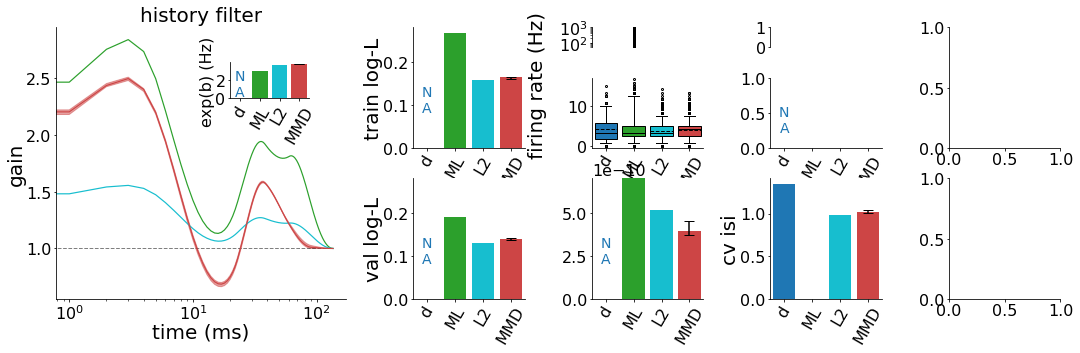

In [61]:
pk_files = [
#             'cimmd_autocov_lammmd4000.0biasedTrue_epochs300_lr0.01.pk',
#             'cimmd_means_product_offset400_lammmd50000.0biasedTrue_epochs400_lr0.01.pk',
#             'cimmd_autocov_offset400_lammmd9000.0biasedTrue_epochs350_lr0.01.pk',
            'cimmd_autocov_offset1_lammmd8000.0biasedTrue_epochs350_lr0.01.pk',
#             'cimmd_autocov_lammmd20000.0biasedTrue_epochs300_lr0.01.pk',
#             'cimmd_autocov_lammmd5000.0biasedTrue_epochs300_lr0.01.pk',
#             'cimmd_autocov_lammmd10000.0biasedTrue_epochs300_lr0.01.pk',
#             'cimmd_autocov_lammmd20000.0biasedTrue_epochs300_lr0.01.pk',
            ]

# fig, (axeta, ax01, ax02, ax03) = plt.subplots(figsize=(15, 5), ncols=4)
# ax00, ax01a, ax01b, ax02, ax03a, ax03b, ax10, ax11, ax12, ax13

widths = 0.8
lw_eta = 1.2
whis = [5, 95]
rotation = 60

fig, (axeta, axll_train, axfra, axfrb, axlabels, axcia, axcib, axll_val, axmuisi, axcv, axac) = plot_layout(figsize=(18, 5))
fig.subplots_adjust(hspace=1.5, wspace=0.6)

# axcv = axmuisi
axac = axmuisi

t_ker = np.arange(0, 137, 1)

axbias = inset_axes(axeta, width=1.1, height=0.5, bbox_to_anchor=(0, 0, .9, .9),
                   bbox_transform=axeta.transAxes)
# myplt.set_labels(axbias, xlabel='', ylabel='exp(b) (Hz)')
axbias.set_ylabel('exp(b) (Hz)', fontsize=tick_labelsize)
axbias.set_yticks([0, 2, 4])
# axbias.set_yticks([0, 5e-3])
# axins1.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useOffset=False)
# axbias.tick_params(axis='both', labelsize=12)
# axbias.set_ylim(-5e-3, 1e-2)

myplt.set_labels(axeta, xlabel='time (ms)', ylabel='gain', title='history filter')
# axeta.legend(frameon=False)
axeta.plot([t_ker[0], t_ker[-1]], [1, 1], 'k--', alpha=0.5, lw=1)
axeta.set_xscale('log')

myplt.set_labels(axll_train, ylabel='train log-L')
myplt.set_labels(axll_val, ylabel='val log-L')

yfr_0a = 50
# axfra.set_yticks([])
axfra.set_ylim(yfr_0a, 1000)
axfra.set_yscale('log')
axfra.get_yaxis().set_minor_formatter(ticker.NullFormatter())

yfr_fb = 17
# myplt.set_labels(axfrb, ylabel='firing rate (Hz)')
axfrb.set_ylabel('firing rate (Hz)')
axfrb.set_ylim(-0.5, yfr_fb)
axfrb.yaxis.set_label_coords(-0.4, 0.9)

myplt.set_labels(axcv, ylabel='cv isi')
    
x0 = -0.5

## DATA
axfra.boxplot(fr_val, positions=[0], patch_artist=True, widths=widths, showmeans=True, meanline=True, 
                      boxprops=dict(facecolor=palette['d']), 
                      meanprops=dict(color='k'), 
                      medianprops=dict(color='k'))
axfrb.boxplot(fr_val, positions=[0], patch_artist=True, widths=widths, showmeans=True, meanline=True, 
                      boxprops=dict(facecolor=palette['d']), 
                      meanprops=dict(color='k'), 
                      medianprops=dict(color='k'), whis=whis)

axcv.bar(0, np.std(isi_val) / np.mean(isi_val), color=palette['d'])

############################### ML
with open(files_folder + 'ml.pk', "rb") as fit_file:
    pk = pickle.load(fit_file)
if pk['offset'] != offset:
    raise
eta_ml = KernelBasisValues(pk['basis'], [0, pk['basis'].shape[0]], 1, coefs=pk['eta_coefs'])
glm_ml = GLM(u0=pk['u0_ml'], eta=eta_ml)
axbias.bar(1, np.exp(glm_ml.u0) * 1000, color=palette['ml'])
glm_ml.eta.plot(t=t_ker, ax=axeta, exp_values=True, lw=lw_eta, color=palette['ml'])

ll_train_ml = -pk['nll_normed_train_ml'][-1]
ll_val_ml = -pk['nll_normed_val_ml'][-1]

isi_fr_ml = pk['isi_fr_ml']
cv_isi_ml_m = np.std(isi_fr_ml) / np.mean(isi_fr_ml)

_, r_fr_ml, mask_spikes_fr_ml = glm_ml.sample(st_val.t, shape=(8000,))
fr_ml = np.sum(mask_spikes_fr_ml, 0) / (mask_spikes_fr_ml.shape[0] * dt) * 1000
autocov_ml = np.mean(auto_covariance(mask_spikes_fr_ml, method='fft', subtract_mean=False, 
                                        stationary_signal=False, biased=False), 1)
# fr_m, fr_0, fr_f = mean_error(fr_m)
autocov_mse_ml = pk['autocov_mse_ml']

axll_train.bar(1, ll_train_ml, color=palette['ml'])
axll_val.bar(1, ll_val_ml, color=palette['ml'])
# axfrb.bar(1, fr_m, color=palette['ml'], yerr=np.array([fr_0, fr_f])[:, None])
axfra.boxplot(fr_ml, positions=[1], patch_artist=True, widths=widths, showmeans=True, meanline=True, 
                      boxprops=dict(facecolor=palette['ml']), 
                      meanprops=dict(color='k'), 
                      medianprops=dict(color='k'))
axfrb.boxplot(fr_ml, positions=[1], patch_artist=True, widths=widths, showmeans=True, meanline=True, 
                      boxprops=dict(facecolor=palette['ml']), 
                      meanprops=dict(color='k'), 
                      medianprops=dict(color='k'), whis=whis)
# axcv.bar(1, cv_isi_ml_m, color=palette['ml'])
axac.bar(1, autocov_mse_ml, color=palette['ml'])#, yerr=np.array([autocov_mse_0, autocov_mse_f])[:, None])


############################### L2
with open(files_folder + 'l2.pk', "rb") as fit_file:
    pk = pickle.load(fit_file)
if pk['offset'] != offset:
    raise
eta_l2 = KernelBasisValues(pk['basis'], [0, pk['basis'].shape[0]], 1, coefs=pk['eta_coefs'])
glm_l2 = GLM(u0=pk['u0_l2'], eta=eta_l2)
axbias.bar(2, np.exp(glm_l2.u0) * 1000, color=palette['l2'])
glm_l2.eta.plot(t=t_ker, ax=axeta, exp_values=True, lw=lw_eta, color=palette['l2'])

ll_train_l2 = -pk['nll_normed_train_l2'][-1]
ll_val_l2 = -pk['nll_normed_val_l2'][-1]

_, r_fr_l2, mask_spikes_fr_l2 = glm_l2.sample(st_val.t, shape=(8000,))
# fr_m = np.sum(mask_spikes_fr_l2, 0) / (mask_spikes_fr_l2.shape[0] * dt) * 1000
fr_l2 = pk['fr_l2']
isi_fr_l2 = pk['isi_fr_l2']
autocov_mse_l2 = pk['autocov_mse_l2']
autocov_l2 = pk['autocov_l2']
autocov_mse_l2 = np.mean((autocov_l2[1:argf_autocor] - autocor_val[1:argf_autocor])**2)
cv_isi_m = np.std(isi_fr_l2) / np.mean(isi_fr_l2)
cv_sd = np.std(isi_fr_l2)
cv_isi_0 = 1.96 * cv_sd
cv_isi_f = 1.96 * cv_sd

# axcv.bar(jj, cv_isi_m, color='C' + str(ii), yerr=np.array([cv_isi_0, cv_isi_f])[:, None])
# fr_m, fr_0, fr_f = mean_error(fr_m)
# autocov_mse_l2_m, autocov_mse_l2_0, autocov_mse_l2_f = mean_error(autocov_mse_l2)

axll_train.bar(2, ll_train_l2, color=palette['l2'])
axll_val.bar(2, ll_val_l2, color=palette['l2'])
# axfrb.bar(1, fr_m, color=palette['l2'], yerr=np.array([fr_0, fr_f])[:, None])
axfra.boxplot(fr_l2, positions=[2], patch_artist=True, widths=widths, showmeans=True, meanline=True, 
                      boxprops=dict(facecolor=palette['l2']), 
                      meanprops=dict(color='k'), 
                      medianprops=dict(color='k'))
axfrb.boxplot(fr_l2, positions=[2], patch_artist=True, widths=widths, showmeans=True, meanline=True, 
                      boxprops=dict(facecolor=palette['l2']), 
                      meanprops=dict(color='k'), 
                      medianprops=dict(color='k'), whis=whis)
axcv.bar(2, cv_isi_m, color=palette['l2'])
axac.bar(2, autocov_mse_l2, color=palette['l2'])
# axac.bar(2, autocov_mse_l2_m, color=palette['l2'], yerr=np.array([autocov_mse_l2_0, autocov_mse_l2_f])[:, None])
# axcv.bar(2, cv_isi_m, color=palette['l2'], yerr=np.array([cv_isi_0, cv_isi_f])[:, None])

# for ii, pk_f in zip(range(len(pk_files)), pk_files):
for ii, pk_f in enumerate(pk_files):
    jj = ii + 3
    with open(files_folder + pk_f, "rb") as fit_file:
        pk = pickle.load(fit_file)
    u0_m = np.mean(pk['u0'])
    g0_m = np.exp(u0_m) * 1000
    g0_0 = g0_m - np.exp(np.percentile(pk['u0'], 2.5)) * 1000
    g0_f = np.exp(np.percentile(pk['u0'], 97.5)) * 1000 - g0_m
    eta_coefs_m = np.mean(pk['eta_coefs'], 1)
    ll_train = pk['ll_train']
    ll_val = pk['ll_val']
    fr_mmd = pk['fr_m']
    fr_mmd = fr_mmd.reshape(-1)
    cv_isi = pk['cv_isi']
    autocor_mse = pk['autocor_mse']
    
    ll_train_m = np.percentile(ll_train, 50)
    ll_train_0 = ll_train_m - np.percentile(ll_train, 2.5)
    ll_train_f = np.percentile(ll_train, 97.5) - ll_train_m
    
    ll_val_m, ll_val_0, ll_val_f = mean_error(ll_val)
#     fr_m, fr_0, fr_f = mean_error(fr_m)
    autocor_mse_m, autocor_mse_0, autocor_mse_f = mean_error(autocor_mse)
    cv_isi_m, cv_isi_0, cv_isi_f = mean_error(cv_isi)
    
    eta_vals = np.dot(pk['basis'], pk['eta_coefs'])
    eta_coefs_0 = np.percentile(eta_vals, 2.5, axis=1)
    eta_coefs_f = np.percentile(eta_vals, 97.5, axis=1)
    eta_mmd = KernelBasisValues(pk['basis'], [0, pk['basis'].shape[0]], 1, coefs=eta_coefs_m)
    mmdglm = GLM(u0=u0_m, eta=eta_mmd)
    axbias.bar(jj, g0_m, yerr=np.array([g0_0, g0_f])[:, None])
    mmdglm.eta.plot(t=t_ker, exp_values=True, ax=axeta, lw=lw_eta, color='C' + str(ii))
    axeta.fill_between(t_ker, np.exp(eta_coefs_0), np.exp(eta_coefs_f), color='C' + str(ii), alpha=0.5)
    axll_train.bar(jj, ll_train_m, color='C' + str(ii), yerr=np.array([ll_train_0, ll_train_f])[:, None])
    axll_val.bar(jj, ll_val_m, color='C' + str(ii), yerr=np.array([ll_val_0, ll_val_f])[:, None])
#     axfrb.bar(jj, fr_m, color='C' + str(ii), yerr=np.array([fr_0, fr_f])[:, None])
    axfra.boxplot(fr_mmd, positions=[jj], patch_artist=True, widths=widths, showmeans=True, meanline=True, 
                          boxprops=dict(facecolor='C' + str(ii)), 
                          meanprops=dict(color='k'), 
                          medianprops=dict(color='k'))
    axfrb.boxplot(fr_mmd, positions=[jj], patch_artist=True, widths=widths, showmeans=True, meanline=True, 
                          boxprops=dict(facecolor='C' + str(ii)), 
                          meanprops=dict(color='k'), 
                          medianprops=dict(color='k'), whis=whis)
    axcv.bar(jj, cv_isi_m, color='C' + str(ii), yerr=np.array([cv_isi_0, cv_isi_f])[:, None])
    axac.bar(jj, autocor_mse_m, color='C' + str(ii), yerr=np.array([autocor_mse_0, autocor_mse_f])[:, None])
    
axac.set_ylim(0, 7e-10)
    
for ax in (axbias, axll_train, axcib, axll_val, axac):
#     ax.text(0.1, 0.5, 'N\nA', color=palette['d'], fontsize=14, horizontalalignment='center', 
#             verticalalignment='center', transform=ax.transAxes)
    yf = ax.get_ylim()[1]
    ax.text(0, yf / 2.5, 'N\nA', color=palette['d'], fontsize=14, horizontalalignment='center', 
            verticalalignment='center')
#     ax.set_xlim(-space, len(pk_files) + 2 + space)

space = 0.5
for ax in (axbias, axll_train, axfra, axfrb, axcia, axcib, axll_val, axmuisi, axcv, axac):
    ax.set_xticks(range(len(pk_files) + 3))
    ax.set_xticklabels(['d', 'ML', 'L2', 'MMD'], rotation=rotation)# + list(range(2, len(pk_files) + 4)))
#     ax.set_xticks(range(2, ii + 3))
#     ax.set_xticklabels(list(range(1, ii + 2)))
    ax.set_xlim(-space, len(pk_files) + 2 + space)
    
# fig.tight_layout()
fig.savefig('./fig4_rebuttal.svg', transparent=True)

In [98]:
#     offset = 100
#     n_train, n_val = pk['n_train'], pk['n_val']
    
#     violinplot(axmuisi, isi_val, 0, widths=widths, showmeans=True, color=palette['d'])
#     axlabels.text(x0, 0.9, 'd: data', transform=axlabels.transAxes, color=palette['d'], fontsize=16, 
#                   horizontalalignment='left', verticalalignment='center')
    


#     ll_train_ml, ll_ml, fr_ml, mu_fr_fr, ci_mse, isi_fr, mu_isi_fr, sd_isi_fr, ci_mse, autocor_mse = observables(glm_ml)
    
#     axfra.boxplot(fr_ml, positions=[1], patch_artist=True, widths=widths, showmeans=True, meanline=True, 
#                           boxprops=dict(facecolor=palette['ml']), 
#                           meanprops=dict(color='k'), 
#                           medianprops=dict(color='k'))
#     axfrb.boxplot(fr_ml, positions=[1], patch_artist=True, widths=widths, showmeans=True, meanline=True, 
#                           boxprops=dict(facecolor=palette['ml']), 
#                           meanprops=dict(color='k'), 
#                           medianprops=dict(color='k'))
#     print('number outliers', np.sum(fr_ml > 100), 'out of', len(fr_ml))
# #     axsdfr.bar(0, sd_fr_fr, color=palette['ml'])
# #     axmuisi.bar(0, mean_isi_fr_ml, color=palette['ml'])
#     violinplot(axmuisi, isi_fr, 1, widths=widths, showmeans=True, color=palette['ml'])
#     axsdisi.bar(1, sd_isi_fr / mu_isi_fr, color=palette['ml'])
#     axcia.bar(1, ci_mse, color=palette['ml'])
#     axcib.bar(1, ci_mse, color=palette['ml'])
#     axac.bar(1, autocor_mse, color=palette['ml'])
#     axlabels.text(x0, 0.9 - 0.15, '0: MLE', transform=axlabels.transAxes, color=palette['ml'], fontsize=16, 
#                   horizontalalignment='left', verticalalignment='center')
        
for ii, pk_f in enumerate(pk_files):
    with open(files_folder + pk_f, "rb") as fit_file:
        pk = pickle.load(fit_file)
        print(ii + 1, 'n_batch_fr', pk['n_batch_fr'])
        
        
#         ll_val, fr_fr, mean_isi_fr, var_isi_fr = observables(mmdglm)
        ll_train, ll_val, fr, mu_fr_fr, sd_fr_fr, isi_fr, mu_isi_fr, sd_isi_fr, ci_mse, autocor_mse = observables(mmdglm)
        print('number outliers', np.sum(fr > 100), 'out of', len(fr))
        
        axll_train.bar(ii + 2, ll_train)
        axll_val.bar(ii + 2, ll_val)
#         axfr.bar(ii + 1, mu_fr_fr)
#         sns.boxplot(x=np.zeros(len(fr)) + ii + 1, y=fr, ax=axfr)
        axfra.boxplot(fr, positions=[ii + 2], patch_artist=True, widths=widths, showmeans=True, meanline=True, 
                          boxprops=dict(facecolor='C' + str(ii)), 
                          meanprops=dict(color='k'), 
                          medianprops=dict(color='k'))
        axfrb.boxplot(fr, positions=[ii + 2], patch_artist=True, widths=widths,showmeans=True, meanline=True, 
                          boxprops=dict(facecolor='C' + str(ii)), 
                          meanprops=dict(color='k'), 
                          medianprops=dict(color='k'))
#         axsdfr.bar(ii + 1, sd_fr_fr)
        violinplot(axmuisi, isi_fr, ii + 2, widths=widths, showmeans=True, color='C' + str(ii))
#         axmuisi.bar(ii + 1, mu_isi_fr)
        axsdisi.bar(ii + 2, sd_isi_fr / mu_isi_fr)
        axcia.bar(ii + 2, ci_mse)
        axcib.bar(ii + 2, ci_mse)
        axac.bar(ii + 2, autocor_mse)
        label = '_'.join(pk_f.split('_')[:2])
#         axlabels.text(0.1, 0.9 - 0.1 * ii, "$\lambda \lambda'$", transform=axsdfr.transAxes)
        if ii == 0:
            axlabels.text(x0, 0.9 - 0.15 * (ii + 2), str(ii + 1) + ': ' + dic_labels[label] + r'  $\alpha$=' \
                          + '$1e^4$', transform=axlabels.transAxes, 
                      color='C' + str(ii), fontsize=16, horizontalalignment='left', verticalalignment='center')
        elif ii == 1:
            axlabels.text(x0, 0.9 - 0.15 * (ii + 2), str(ii + 1) + ': ' + dic_labels[label] + r'  $\alpha$=' \
                          + '$5e^4$', transform=axlabels.transAxes, 
                      color='C' + str(ii), fontsize=16, horizontalalignment='left', verticalalignment='center')
        else:
            axlabels.text(x0, 0.9 - 0.15 * (ii + 2), str(ii + 1) + ': ' + dic_labels[label], transform=axlabels.transAxes, 
                      color='C' + str(ii), fontsize=16, horizontalalignment='left', verticalalignment='center')

yfr_0a = 50
# axfra.set_yticks([])
axfra.set_ylim(yfr_0a, 1000)
axfra.set_yscale('log')
axfra.get_yaxis().set_minor_formatter(ticker.NullFormatter())
# axfra.get_yaxis().get_major_formatter().labelOnlyBase = False
# 
# axfra.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

yfr_fb = 17
# myplt.set_labels(axfrb, ylabel='firing rate (Hz)')
axfrb.set_ylabel('firing rate (Hz)')
axfrb.set_ylim(-0.5, yfr_fb)
axfrb.yaxis.set_label_coords(-0.4, 0.9)

# myplt.set_labels(axsdfr, ylabel='sd firing rate (Hz)')
myplt.set_labels(axmuisi, ylabel='isi (ms)')

y0a = 10
axcia.set_yscale('log')
axcia.set_ylim(y0a, 1e15)

yfb = 1e-6
# axcib.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axcib.set_yscale('log')
axcib.set_ylim(1e-8, yfb)
axcib.yaxis.set_label_coords(-0.5, 0.9)

axac.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
myplt.set_labels(axcib, ylabel='$\sum (\lambda_{dc} - \lambda_{fr})^2/T$')

# axsdfr.text(0.1, 0.1, '$\bar{\lambda} \bar{\lambda}$', transform=axsdfr.transAxes)

myplt.set_labels(axac, ylabel='rmse autocor')
axac.set_yscale('log')
axac.set_yticks([1e-4, 1e-3])
# axac.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

for ax in (axbias, axll_train, axfra, axfrb, axcia, axcib, axll_val, axmuisi, axsdisi, axac):
    ax.set_xticks(range(ii + 3))
    ax.set_xticklabels(['d', '0'] + list(range(1, ii + 2)))
#     ax.set_xticks(range(2, ii + 3))
#     ax.set_xticklabels(list(range(1, ii + 2)))
    ax.set_xlim(-1, ii + 3)
    
myplt.set_scale_bars(axlabels)

# fig.savefig('/home/diego/Dropbox/generative_glm/figures/fig4.pdf', transparent=True)

KeyError: 'n_batch_fr'

In [28]:
np.mean(fr_val)

2.9504132231404956